# Implementing ResNet-18 Using Keras

In this note book I will try to implement ResNet-18 using Keras and compare my implementation with the standard implementation provided in keras.application

## preprocess

In [1]:

import os
import sys
import sklearn
import pip
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import deeplake
from time import time
from PIL import Image


from pathlib import Path
# set figure size
plt.rcParams['figure.figsize'] = [14, 14]
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Requirements taken from https://www.tensorflow.org/install/pip#linux
python_version = sys.version
pip_version = pip.__version__
nvidia_smi_version = os.popen('nvidia-smi --query-gpu=driver_version --format=csv,noheader').read().strip()
cuda_version = os.popen('nvcc --version').read().split('\n')[3].split(',')[1].strip()
tensorflow_version = tf.__version__
physical_devices = tf.config.list_physical_devices('GPU')
num_gpus = len(physical_devices)
gpu_model = os.popen('nvidia-smi --query-gpu=name --format=csv,noheader').read().strip()

req_xray_data = pd.DataFrame({
    'Package': ['Python', 'pip', 'nvidia-smi', 'cuda', 'tensorflow', 'GPUs'],
    'Required': ['3.7', '20.2', '450.51.06', '11.0', '2.3.0', '1'],
    'Installed': [python_version, pip_version, nvidia_smi_version, cuda_version, tensorflow_version, num_gpus]
})
               
print(f'All requiremetns met. Using TF with GPU: {gpu_model} ({num_gpus}x)')

pd.options.plotting.backend = "plotly"
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

from keras.models import Model, Sequential
from keras.layers import Lambda, Input, GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import keras
from sklearn.metrics import classification_report, accuracy_score

import sys

sys.path.append('/home/kayaba_attribution/Documents/UoL/FINAL_PROJECT/Code/nih-chest')
sys.path.append(os.path.dirname(os.getcwd()))

from dataset import train_ds, val_ds, test_ds, y_test, y_val, ALL_LABELS, IMG_SIZE
from reportUtils import generate_report

MODEL_NAME = 'ResNet18'

req_xray_data


2024-03-10 21:33:04.240645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 21:33:04.240684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 21:33:04.241560: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-10 21:33:04.246973: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 21:33:04.948088: W tensorflow/compiler/tf2

All requiremetns met. Using TF with GPU: NVIDIA GeForce GTX 1660 (1x)
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


2024-03-10 21:33:06.135756: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355



Train size: X: 61540, y: 61540 | Validation size: X: 15385, y: 15385 | Test size: X: 35195, y: 35195 | 
Total size: X: 112120


2024-03-10 21:33:06.449621: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-10 21:33:06.449876: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-10 21:33:06.450076: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

ModuleNotFoundError: No module named 'report'

# Implement ResNet-18 model

Codes below are taken from my [Github](https://github.com/songrise/CNN_Keras)

In [4]:
"""
ResNet-18
Reference:
[1] K. He et al. Deep Residual Learning for Image Recognition. CVPR, 2016
[2] K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers:
Surpassing human-level performance on imagenet classification. In
ICCV, 2015.
"""

from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf

class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out



In [7]:
model = ResNet18(15)

model.build(input_shape = (None,IMG_SIZE,IMG_SIZE,3))

plot_model(model, f"{MODEL_NAME}_model.png", show_shapes=True, show_layer_names=True)
weight_path=f"{MODEL_NAME}_weights.best.hdf5".format('Basic_CNN')

# https://keras.io/api/callbacks/model_checkpoint/
checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_loss',
    verbose=1, 
    save_best_only=True,
    mode='min',
    save_weights_only = True)

# https://keras.io/api/callbacks/early_stopping/
earlystop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 1e-4,
    patience = 5,
    mode = 'min', 
    restore_best_weights = True,
    verbose = 1)

# https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=1e-4,
    cooldown=1,
    min_lr=1e-6)


callbacks_list = [checkpoint, earlystop, reduceLROnPlat]


model.compile(optimizer='adam', 
              loss=keras.losses.BinaryCrossentropy(label_smoothing=0.0), 
                metrics=[
                    keras.metrics.BinaryAccuracy(name='accuracy'),
                    keras.metrics.Precision(name='precision'),
                    keras.metrics.Recall(name='recall'),
                    keras.metrics.AUC(name='auc', multi_label=True)])

model.summary()

Model: "res_net18_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_20 (Ba  multiple                  256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_1 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 resnet_block_8 (ResnetBloc  multiple                  74368     
 k)                                                              
                                                                 
 resnet_block_9 (ResnetBloc  multiple                  74368     
 k)                                                    

In [15]:
# Check if weight checkpoint exists
if os.path.exists(weight_path):
    print("Loading weights from:", weight_path)
    model.load_weights(weight_path)
else:
    print("No weights found, starting training from scratch.")

start = time()
Basic_CNN_history = model.fit(
                    train_ds,
                    epochs=8,
                    validation_data=val_ds,
                    callbacks=callbacks_list
                    )
print('\nTraining took {} sec'.format((time()-start)))
model.save(f"{MODEL_NAME}.keras")


Loading weights from: ResNet18_weights.best.hdf5
Epoch 1/8
 210/3847 [>.............................] - ETA: 6:12 - loss: 0.1223 - accuracy: 0.9344 - precision: 0.8651 - recall: 0.4339 - auc: 0.8604

2024-03-10 19:42:52.898459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


1437/3847 [==========>...................] - ETA: 4:07 - loss: 0.1189 - accuracy: 0.9344 - precision: 0.8604 - recall: 0.4381 - auc: 0.8639

2024-03-10 19:44:59.011864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


1924/3847 [==============>...............] - ETA: 3:17 - loss: 0.1162 - accuracy: 0.9349 - precision: 0.8620 - recall: 0.4428 - auc: 0.8677

2024-03-10 19:45:49.234440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


3846/3847 [============================>.] - ETA: 0s - loss: 0.1047 - accuracy: 0.9374 - precision: 0.8747 - recall: 0.4637 - auc: 0.8735
Epoch 1: val_loss improved from 0.16786 to 0.12840, saving model to ResNet18_weights.best.hdf5
3847/3847 [==============================] - 425s 111ms/step - loss: 0.1047 - accuracy: 0.9374 - precision: 0.8747 - recall: 0.4637 - auc: 0.8735 - val_loss: 0.1284 - val_accuracy: 0.9343 - val_precision: 0.8144 - val_recall: 0.4696 - val_auc: 0.8359 - lr: 0.0010
Epoch 2/8
 210/3847 [>.............................] - ETA: 6:12 - loss: 0.0813 - accuracy: 0.9437 - precision: 0.9006 - recall: 0.5126 - auc: 0.8951

2024-03-10 19:49:58.073228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


1437/3847 [==========>...................] - ETA: 4:08 - loss: 0.0767 - accuracy: 0.9447 - precision: 0.9050 - recall: 0.5211 - auc: 0.8937

2024-03-10 19:52:04.791419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


1923/3847 [=============>................] - ETA: 3:18 - loss: 0.0749 - accuracy: 0.9453 - precision: 0.9080 - recall: 0.5251 - auc: 0.8943

2024-03-10 19:52:55.179900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


3846/3847 [============================>.] - ETA: 0s - loss: 0.0668 - accuracy: 0.9471 - precision: 0.9185 - recall: 0.5392 - auc: 0.8973
Epoch 2: val_loss improved from 0.12840 to 0.11938, saving model to ResNet18_weights.best.hdf5
3847/3847 [==============================] - 426s 111ms/step - loss: 0.0668 - accuracy: 0.9471 - precision: 0.9185 - recall: 0.5392 - auc: 0.8973 - val_loss: 0.1194 - val_accuracy: 0.9370 - val_precision: 0.8285 - val_recall: 0.4903 - val_auc: 0.8353 - lr: 0.0010
Epoch 3/8
 210/3847 [>.............................] - ETA: 6:16 - loss: 0.0496 - accuracy: 0.9524 - precision: 0.9458 - recall: 0.5724 - auc: 0.9084

2024-03-10 19:57:04.418992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


1437/3847 [==========>...................] - ETA: 4:08 - loss: 0.0477 - accuracy: 0.9526 - precision: 0.9448 - recall: 0.5763 - auc: 0.9039

2024-03-10 19:59:11.129044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


1924/3847 [==============>...............] - ETA: 3:18 - loss: 0.0470 - accuracy: 0.9527 - precision: 0.9445 - recall: 0.5777 - auc: 0.9043

2024-03-10 20:00:01.447408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


3846/3847 [============================>.] - ETA: 0s - loss: 0.0419 - accuracy: 0.9537 - precision: 0.9505 - recall: 0.5850 - auc: 0.9053
Epoch 3: val_loss did not improve from 0.11938
3847/3847 [==============================] - 426s 111ms/step - loss: 0.0419 - accuracy: 0.9537 - precision: 0.9505 - recall: 0.5850 - auc: 0.9053 - val_loss: 0.1308 - val_accuracy: 0.9371 - val_precision: 0.8189 - val_recall: 0.4999 - val_auc: 0.8227 - lr: 0.0010
Epoch 4/8
 210/3847 [>.............................] - ETA: 6:13 - loss: 0.0344 - accuracy: 0.9564 - precision: 0.9620 - recall: 0.6023 - auc: 0.9040

2024-03-10 20:04:10.206506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


1437/3847 [==========>...................] - ETA: 4:09 - loss: 0.0320 - accuracy: 0.9566 - precision: 0.9638 - recall: 0.6042 - auc: 0.9078

2024-03-10 20:06:17.158806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


1924/3847 [==============>...............] - ETA: 3:19 - loss: 0.0314 - accuracy: 0.9568 - precision: 0.9643 - recall: 0.6055 - auc: 0.9071

2024-03-10 20:07:07.796576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


3846/3847 [============================>.] - ETA: 0s - loss: 0.0287 - accuracy: 0.9572 - precision: 0.9679 - recall: 0.6082 - auc: 0.9057
Epoch 4: val_loss improved from 0.11938 to 0.11067, saving model to ResNet18_weights.best.hdf5
3847/3847 [==============================] - 427s 111ms/step - loss: 0.0287 - accuracy: 0.9572 - precision: 0.9679 - recall: 0.6082 - auc: 0.9057 - val_loss: 0.1107 - val_accuracy: 0.9419 - val_precision: 0.8526 - val_recall: 0.5269 - val_auc: 0.8507 - lr: 0.0010
Epoch 5/8
 210/3847 [>.............................] - ETA: 6:15 - loss: 0.0232 - accuracy: 0.9586 - precision: 0.9722 - recall: 0.6173 - auc: 0.9112

2024-03-10 20:11:16.902746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


1437/3847 [==========>...................] - ETA: 4:08 - loss: 0.0234 - accuracy: 0.9587 - precision: 0.9745 - recall: 0.6178 - auc: 0.9053

2024-03-10 20:13:23.551285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


1924/3847 [==============>...............] - ETA: 3:18 - loss: 0.0234 - accuracy: 0.9587 - precision: 0.9744 - recall: 0.6177 - auc: 0.9061

2024-03-10 20:14:13.805470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


3846/3847 [============================>.] - ETA: 0s - loss: 0.0217 - accuracy: 0.9589 - precision: 0.9772 - recall: 0.6187 - auc: 0.9046
Epoch 5: val_loss did not improve from 0.11067
3847/3847 [==============================] - 426s 111ms/step - loss: 0.0217 - accuracy: 0.9589 - precision: 0.9772 - recall: 0.6187 - auc: 0.9046 - val_loss: 0.1218 - val_accuracy: 0.9435 - val_precision: 0.8572 - val_recall: 0.5423 - val_auc: 0.8236 - lr: 0.0010
Epoch 6/8
 210/3847 [>.............................] - ETA: 6:18 - loss: 0.0192 - accuracy: 0.9602 - precision: 0.9823 - recall: 0.6270 - auc: 0.9017

2024-03-10 20:18:23.021738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


1437/3847 [==========>...................] - ETA: 4:09 - loss: 0.0180 - accuracy: 0.9601 - precision: 0.9826 - recall: 0.6256 - auc: 0.8991

2024-03-10 20:20:29.699888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


1924/3847 [==============>...............] - ETA: 3:18 - loss: 0.0179 - accuracy: 0.9601 - precision: 0.9828 - recall: 0.6258 - auc: 0.8996

2024-03-10 20:21:20.165135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


3846/3847 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9600 - precision: 0.9836 - recall: 0.6253 - auc: 0.8985
Epoch 6: val_loss did not improve from 0.11067

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
3847/3847 [==============================] - 427s 111ms/step - loss: 0.0170 - accuracy: 0.9600 - precision: 0.9836 - recall: 0.6253 - auc: 0.8985 - val_loss: 0.1250 - val_accuracy: 0.9426 - val_precision: 0.8508 - val_recall: 0.5365 - val_auc: 0.8256 - lr: 0.0010
Epoch 7/8
 210/3847 [>.............................] - ETA: 6:13 - loss: 0.0136 - accuracy: 0.9609 - precision: 0.9868 - recall: 0.6303 - auc: 0.9009

2024-03-10 20:25:29.581726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


1437/3847 [==========>...................] - ETA: 4:08 - loss: 0.0110 - accuracy: 0.9613 - precision: 0.9901 - recall: 0.6328 - auc: 0.8973

2024-03-10 20:27:36.163149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


1924/3847 [==============>...............] - ETA: 3:18 - loss: 0.0101 - accuracy: 0.9614 - precision: 0.9908 - recall: 0.6333 - auc: 0.8976

2024-03-10 20:28:26.331735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


3846/3847 [============================>.] - ETA: 0s - loss: 0.0070 - accuracy: 0.9617 - precision: 0.9943 - recall: 0.6348 - auc: 0.8967
Epoch 7: val_loss improved from 0.11067 to 0.10770, saving model to ResNet18_weights.best.hdf5
3847/3847 [==============================] - 426s 111ms/step - loss: 0.0070 - accuracy: 0.9617 - precision: 0.9943 - recall: 0.6348 - auc: 0.8967 - val_loss: 0.1077 - val_accuracy: 0.9484 - val_precision: 0.8907 - val_recall: 0.5694 - val_auc: 0.8481 - lr: 1.0000e-04
Epoch 8/8
 210/3847 [>.............................] - ETA: 6:18 - loss: 0.0023 - accuracy: 0.9628 - precision: 0.9988 - recall: 0.6408 - auc: 0.9073

2024-03-10 20:32:36.044779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


1437/3847 [==========>...................] - ETA: 4:09 - loss: 0.0017 - accuracy: 0.9628 - precision: 0.9998 - recall: 0.6408 - auc: 0.8972

2024-03-10 20:34:42.778020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


1924/3847 [==============>...............] - ETA: 3:18 - loss: 0.0015 - accuracy: 0.9628 - precision: 0.9998 - recall: 0.6408 - auc: 0.8953

2024-03-10 20:35:33.140149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


3846/3847 [============================>.] - ETA: 0s - loss: 9.6772e-04 - accuracy: 0.9625 - precision: 0.9999 - recall: 0.6396 - auc: 0.8891
Epoch 8: val_loss did not improve from 0.10770
3847/3847 [==============================] - 427s 111ms/step - loss: 9.6766e-04 - accuracy: 0.9625 - precision: 0.9999 - recall: 0.6396 - auc: 0.8891 - val_loss: 0.1354 - val_accuracy: 0.9486 - val_precision: 0.8900 - val_recall: 0.5716 - val_auc: 0.8315 - lr: 1.0000e-04

Training took 3409.47026014328 sec


## train curve

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'lr'])


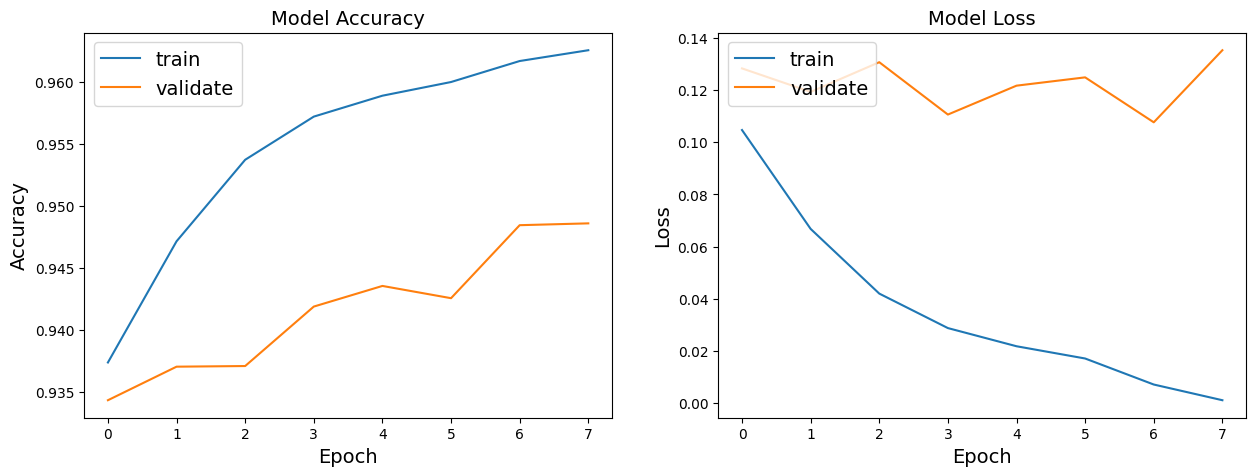

In [16]:

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(Basic_CNN_history.history.keys())
plotmodelhistory(Basic_CNN_history)

# TOTAL EPOCHS = 10

##  Prediction

In [35]:
generate_report(model, val_ds, y_val, MODEL_NAME, ALL_LABELS)

103/962 [==>...........................] - ETA: 27s

KeyboardInterrupt: 

In [28]:
generate_report(model, test_ds, y_test, MODEL_NAME, ALL_LABELS, "test")

2200/2200 [==============================] - 66s 30ms/step


/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
No Finding,0.145131,0.602108,0.233887,4270.0
Hernia,0.000000,0.000000,0.000000,14821.0
Emphysema,0.079470,0.037872,0.051298,2218.0
Nodule,0.034682,0.008845,0.014096,2035.0
Pneumonia,0.153846,0.002207,0.004351,4532.0
Consolidation,0.071882,0.016346,0.026635,2080.0
Cardiomegaly,0.182692,0.015115,0.027921,1257.0
Effusion,0.264036,0.198164,0.226406,4794.0
Mass,0.088983,0.022909,0.036437,2750.0
Pleural_Thickening,0.030864,0.003367,0.006072,1485.0
